<a href="https://colab.research.google.com/github/GeorgeSakketos/Data_Mining_Exercice_02/blob/main/Data_Mining_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Μέρος 1**

In [7]:
# Dependences
!pip install transformers emoji langdetect langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 52.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 87.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=4c25206c3b7f6d147a4557aff0cd3b76c8a7b16515df7f3bbf97bf6bbc57f214
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=b79a43210fab77bb13648dda6ef5e156fcfd67f8544198cf78f9140e126c3d10
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langdetect langid


In [17]:
import pandas as pd
import numpy as np
from transformers import pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from gensim.models import Word2Vec
from langdetect import detect
import string
import re
import nltk
import sys

nltk.download('stopwords')
nltk.download('punkt')

print('Python version ' + sys.version)

filePath = '/content/gdrive/My Drive/Data_Mining_CSV/2023/'

Python version 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


June

In [ ]:
#Read June CSV
filePath_june = filePath + 'june/'
june_listings_2023 = pd.read_csv(filePath_june + 'reviews.csv', thousands = ',')

# Keep the Columns we want
june_listings_2023 = june_listings_2023[['id', 'comments']]

March

In [ ]:
#Read March CSV
filePath_march = filePath + 'march/'
march_listings_2023 = pd.read_csv(filePath_march + 'reviews.csv', thousands = ',')

# Keep the Columns we want
march_listings_2023 = march_listings_2023[['id', 'comments']]

September

In [ ]:
#Read September CSV
filePath_september = filePath + 'september/'
september_listings_2023 = pd.read_csv(filePath_september + 'reviews.csv', thousands = ',')

# Keep the Columns we want
september_listings_2023 = september_listings_2023[['id', 'comments']]

Combine Dataframes

In [ ]:
dfs = [june_listings_2023, march_listings_2023, september_listings_2023]

# Combine June, March and September into one Dataframe
final_reviews_2023 = pd.concat(dfs, ignore_index = True)

# Reset Index
final_reviews_2023 = final_reviews_2023.reset_index(drop=True)

Clean the Data

In [ ]:
# Rename 'comments' column to 'review'
final_reviews_2023 = final_reviews_2023.rename(columns={"comments": "review"})

# Remove NaN lines
final_reviews_2023 = final_reviews_2023.dropna()

# Remove Duplicate IDs
final_reviews_2023 = final_reviews_2023.drop_duplicates(subset='id', keep='first')

# Convert 'review' to lowercase
final_reviews_2023['review'] = final_reviews_2023['review'].str.lower()

# Remove emojis
final_reviews_2023['review'] = final_reviews_2023['review'].str.replace(r'[\U0001F600-\U0001F64F]', '', regex=True)  # emoticons
final_reviews_2023['review'] = final_reviews_2023['review'].str.replace(r'[\U0001F300-\U0001F5FF]', '', regex=True)  # symbols & pictographs
final_reviews_2023['review'] = final_reviews_2023['review'].str.replace(r'[\U0001F680-\U0001F6FF]', '', regex=True)  # transport & map symbols
final_reviews_2023['review'] = final_reviews_2023['review'].str.replace(r'[\U0001F1E0-\U0001F1FF]', '', regex=True)  # flags (iOS)

# Remove URLs
final_reviews_2023['review'] = final_reviews_2023['review'].str.replace(r'http\S+|www.\S+', '', regex=True)

# Remove hashtags
final_reviews_2023['review'] = final_reviews_2023['review'].str.replace(r'#\w+', '', regex=True)

# Remove special characters (keeping only alphanumeric and spaces)
final_reviews_2023['review'] = final_reviews_2023['review'].str.replace(r'[^A-Za-z0-9 ]+', '', regex=True)

# Remove stopwords
stop_words = set(stopwords.words('english'))
final_reviews_2023['review'] = final_reviews_2023['review'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

final_reviews_2023 = final_reviews_2023.reset_index(drop = True)
pd.set_option('display.max_colwidth', None)
print(final_reviews_2023['review'])

0                                                                                                                                                                                                                                                                              apartment wonderful fully equiped beautiful decor comfortable verry clean would stay possibly another host properties close metro markets grocery store conveniences
1         emmanouil excellent host provided us everything need make feel right home gave us tips directions destinations even prior trip kept close contact gave us specific easy instructions get place place spacious comfortable everything neat organized always great place come back adventurous day athens transportation easily accessible place located quiet neighborhood stay amazing experience wouldnt hesitate stay recommend friends
2                                                                                                                               

Export Dataframe to CSV

In [ ]:
final_reviews_2023.to_csv('/content/gdrive/My Drive/Data_Mining_CSV/2023/comments_2023.csv', index = False)

Open comments_2023 CSV

In [ ]:
comments_2023 = pd.read_csv(filePath + 'comments_2023.csv')

Keep Only English Reviews

In [ ]:
import langid

def is_english(text):
    lang, _ = langid.classify(text)
    return lang == 'en'

# Copy the first 50000 reviews and drop rows with NaN values in the 'review' column
english_reviews_2023 = comments_2023.head(10000).copy().dropna(subset=['review'])

# Apply the is_english function
english_reviews_2023.loc[:, 'is_english'] = english_reviews_2023['review'].apply(is_english)

# Filter reviews that are in English
english_reviews_2023 = english_reviews_2023[english_reviews_2023['is_english']]

print(len(english_reviews_2023))

8126


Use HuggingFace Model

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

english_reviews_2023 = english_reviews_2023.head(1000)

# Create a copy
english_reviews_2023 = english_reviews_2023.copy()

# Model
model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/sentiment-roberta-large-english-3-classes")
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/sentiment-roberta-large-english-3-classes")
nlp = pipeline("text-classification",model = model,tokenizer = tokenizer)

# Batch Size (ex. 100)
batch_size = 100

# Function to split reviews into chunks and process them
def batch_process_reviews(reviews, batch_size):
  sentiments = []
  for i in range(0, len(reviews), batch_size):
    print(i)
    batch = reviews[i:i + batch_size]
    results = nlp(batch.tolist())
    sentiments.extend([result['label'] for result in results])
  return sentiments

# Process reviews and get sentiments
reviews = english_reviews_2023['review']
english_reviews_2023['sentiment'] = batch_process_reviews(reviews, batch_size)

print(english_reviews_2023.tail(30))

Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
100
200
300
400
500
600
700
800
900
             id  \
1209   42132595   
1210   42880906   
1212   46293806   
1213   46898313   
1214   47372696   
1215   48403285   
1216   49349061   
1218   50110504   
1220   51076992   
1221   52156958   
1222  506142716   
1223  507120567   
1224  508563746   
1225  510635774   
1226   15862307   
1227   15903565   
1228   15960120   
1229   16015311   
1230   16200492   
1231   16372257   
1232   16452740   
1233   16618774   
1235   16976482   
1236   17059710   
1237   17246247   
1238   17266918   
1239  519780429   
1241  524486588   
1242  525166229   
1245   52999674   

                                                                                                                                                                                                                                                                                                                                                                                    

Chart Results

sentiment
positive    885
neutral      96
negative     19
Name: count, dtype: int64


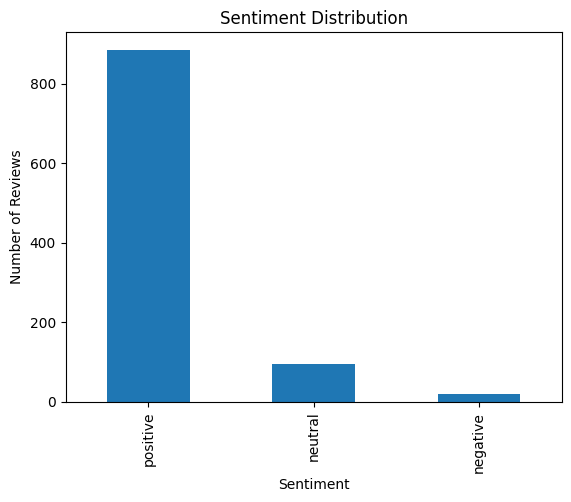

In [ ]:
import matplotlib.pyplot as plt

reviews_2023 = english_reviews_2023.copy()

# Drop 'is_english' column
reviews_2023 = reviews_2023.drop(['is_english'], axis = 1)
reviews_2023 = reviews_2023.reset_index(drop = True)

# Plot the Histogram
sentiment_count = reviews_2023['sentiment'].value_counts()
print(sentiment_count)
sentiment_count.plot(kind='bar')

# Title and Label
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')

# Show Plot
plt.show()

Export Resulting Dataframe

In [ ]:
reviews_2023 = reviews_2023.reset_index(drop = True)
reviews_2023.to_csv('/content/gdrive/My Drive/Data_Mining_CSV/2023/reviews_2023.csv', index = False)

# **Μέρος 2**

Open File

In [ ]:
reviews_2023 = pd.read_csv(filePath + 'reviews_2023.csv')

Match Sentiments with numbers (positive = 1, neutral = 0, negative = 2)

In [ ]:
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': 2}
reviews_2023['sentiment'] = reviews_2023['sentiment'].map(sentiment_mapping)

print(reviews_2023.head())

         id                                             review  sentiment
0    271535  apartment wonderful fully equiped beautiful de...          1
1   1994237  emmanouil excellent host provided us everythin...          1
2  12184199  wife daughter spent five days beauty light col...          1
3  13197921  great stay soulas apartment loved decoration f...          1
4  13393565  beautiful clean apartment plenty space stayed ...          1


Prepare Data Points

In [ ]:
from sklearn.model_selection import train_test_split

train_reviews, test_reviews = train_test_split(reviews_2023, test_size = 0.2, random_state = 42)

# Save to .tsv format
train_reviews.to_csv(filePath + 'train.tsv', sep='\t', index = False)
test_reviews.to_csv(filePath + 'test.tsv', sep='\t', index = False)

Characteristics Preparation with TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_reviews['review'] = train_reviews['review'].fillna('')
test_reviews['review'] = test_reviews['review'].fillna('')

# Vectorizer Creation
tfidf_Vectorizer = TfidfVectorizer(max_df=0.1, min_df=1, max_features=200)

# Convert to TF-IDF train data reviews
X_train_tfidf = tfidf_Vectorizer.fit_transform(train_reviews['review'])

# Convert to TF-IDF test data reviews
X_test_tfidf = tfidf_Vectorizer.fit_transform(test_reviews['review'])

# Shape Check
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(800, 200)
(200, 200)


Characteristics Preparation with Word Embeddings using Word2Vec model

In [ ]:
# Seperate reviews to words
train_sentence = [review.split() for review in train_reviews['review']]
test_sentence = [review.split() for review in test_reviews['review']]

# Train Word2Vec model
word2vecModel = Word2Vec(sentences=train_sentence, vector_size=200, window=5, min_count=1, workers=4, seed=42)

# Function for calculating the mean of words to get the embedding for the review
def embedding_review(review, model):
  words = review.split()
  word_vectors = [model.wv[word] for word in words if word in model.wv]
  if len(word_vectors) == 0:
    return np.zeros(model.vector_size)
  else:
    return np.mean(word_vectors, axis=0)

# Train dataset using Word Embeddings
X_train_embeddings = np.vstack([embedding_review(review, word2vecModel) for review in train_reviews['review']])

# Test dataset using Word Embeddings
X_test_embeddings = np.vstack([embedding_review(review, word2vecModel) for review in test_reviews['review']])

# Shape Check
print(X_train_embeddings.shape)
print(X_test_embeddings.shape)

(800, 200)
(200, 200)


Save to pickle file

In [ ]:
import pickle

# Save TF-IDF Files
with open(filePath + 'X_train_tfidf.pkl', 'wb') as file:
  pickle.dump(X_train_tfidf, file)

with open(filePath + 'X_test_tfidf.pkl', 'wb') as file:
  pickle.dump(X_test_tfidf, file)

# Save Word2Vec Files
with open(filePath + 'X_train_embeddings.pkl', 'wb') as file:
  pickle.dump(X_train_embeddings, file)

with open(filePath + 'X_test_embeddings.pkl', 'wb') as file:
  pickle.dump(X_test_embeddings, file)

# Save TF-IDF Vectorizer
with open(filePath + 'tfidf_vectorizer.pkl', 'wb') as file:
  pickle.dump(tfidf_Vectorizer, file)

# Save Sentiments
with open(filePath + 'Y_train_reviews.pkl', 'wb') as file:
  pickle.dump(train_reviews['sentiment'].values, file)

with open(filePath + 'Y_test_reviews.pkl', 'wb') as file:
  pickle.dump(test_reviews['sentiment'].values, file)

Load from pickle file

In [ ]:
import pickle

# Load TF-IDF Files
with open(filePath + 'X_train_tfidf.pkl', 'rb') as file:
  X_train_tfidf = pickle.load(file)

with open(filePath + 'X_test_tfidf.pkl', 'rb') as file:
  X_test_tfidf = pickle.load(file)

# Load Word2Vec Files
with open(filePath + 'X_train_embeddings.pkl', 'rb') as file:
  X_train_embeddings = pickle.load(file)

with open(filePath + 'X_test_embeddings.pkl', 'rb') as file:
  X_test_embeddings = pickle.load(file)

# Load TF-IDF Vectorizer
with open(filePath + 'tfidf_vectorizer.pkl', 'rb') as file:
  tfidf_Vectorizer = pickle.load(file)

# Load Sentiments
with open(filePath + 'Y_train_reviews.pkl', 'rb') as file:
  Y_train_reviews = pickle.load(file)

with open(filePath + 'Y_test_reviews.pkl', 'rb') as file:
  Y_test_reviews = pickle.load(file)

For TF-IDF Characteristics we use SVM sorting

In [ ]:
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

# Custom scorer functions to handle zero_division
def precision_macro(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[0]

def recall_macro(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[1]

def f1_macro(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[2]

# Define custom scorers
scoring = {
    'precision_macro': make_scorer(precision_macro),
    'recall_macro': make_scorer(recall_macro),
    'f1_macro': make_scorer(f1_macro),
    'accuracy': 'accuracy'
}

# Load Classifer
classifier_svm = svm.SVC()

# Train SVM
classifier_svm.fit(X_train_tfidf, Y_train_reviews)

# Predict at test data
Y_pred_svm = classifier_svm.predict(X_test_tfidf)

# Evaluate Classifier using Cross-Validation
scores = cross_validate(classifier_svm, X_train_tfidf, Y_train_reviews, cv=10, scoring=scoring)

# Print Cross-Validation Results
print(f"Cross-Validation Results:")
print(f"Precision: {np.mean(scores['test_precision_macro']):.4f}")
print(f"Recall: {np.mean(scores['test_recall_macro']):.4f}")
print(f"F1 Score: {np.mean(scores['test_f1_macro']):.4f}")
print(f"Accuracy: {np.mean(scores['test_accuracy']):.4f}")
print("\n")

# Evaluate Test Data
test_accuracy = accuracy_score(Y_test_reviews, Y_pred_svm)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(Y_test_reviews, Y_pred_svm, average='macro', zero_division=0)

# Print Results
print("Test Data Results:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Cross-Validation Results:
Precision: 0.4996
Recall: 0.3815
F1 Score: 0.3876
Accuracy: 0.9000


Test Data Results:
Test Accuracy: 0.8850
Test Precision: 0.6281
Test Recall: 0.3500
Test F1 Score: 0.3446


For TF-IDF Characteristics we use Random Forests sorting

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

# Custom scorer functions to handle zero_division
def precision_macro(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[0]

def recall_macro(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[1]

def f1_macro(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[2]

# Define custom scorers
scoring = {
    'precision_macro': make_scorer(precision_macro),
    'recall_macro': make_scorer(recall_macro),
    'f1_macro': make_scorer(f1_macro),
    'accuracy': 'accuracy'
}

# Load Classifier
classifier_rf = RandomForestClassifier()

# Train Random Forest
classifier_rf.fit(X_train_tfidf, Y_train_reviews)

# Predict at test data
Y_pred_rf = classifier_rf.predict(X_test_tfidf)

# Evaluate Classifier using Cross-Validation
scores = cross_validate(classifier_rf, X_train_tfidf, Y_train_reviews, cv=10, scoring=scoring)

# Print Cross-Validation Results
print(f"Cross-Validation Results:")
print(f"Precision: {np.mean(scores['test_precision_macro']):.4f}")
print(f"Recall: {np.mean(scores['test_recall_macro']):.4f}")
print(f"F1 Score: {np.mean(scores['test_f1_macro']):.4f}")
print(f"Accuracy: {np.mean(scores['test_accuracy']):.4f}")
print("\n")

# Evaluate Test Data
test_accuracy = accuracy_score(Y_test_reviews, Y_pred_rf)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(Y_test_reviews, Y_pred_rf, average='macro', zero_division=0)

# Print Results
print("Test Data Results:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Cross-Validation Results:
Precision: 0.5436
Recall: 0.4297
F1 Score: 0.4399
Accuracy: 0.8975


Test Data Results:
Test Accuracy: 0.8800
Test Precision: 0.6279
Test Recall: 0.3481
Test F1 Score: 0.3437


For TF-IDF Characteristics we use KNN sorting

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

# Custom scorer functions to handle zero_division
def precision_macro(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[0]

def recall_macro(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[1]

def f1_macro(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[2]

# Define custom scorers
scoring = {
    'precision_macro': make_scorer(precision_macro),
    'recall_macro': make_scorer(recall_macro),
    'f1_macro': make_scorer(f1_macro),
    'accuracy': 'accuracy'
}

# Load Classifier
classifier_knn = KNeighborsClassifier()

# Train KNN
classifier_knn.fit(X_train_tfidf, Y_train_reviews)

# Predict at test data
Y_pred_knn = classifier_knn.predict(X_test_tfidf)

# Evaluate Classifier using Cross-Validation
scores = cross_validate(classifier_knn, X_train_tfidf, Y_train_reviews, cv=10, scoring=scoring)

# Print Cross-Validation Results
print(f"Cross-Validation Results:")
print(f"Precision: {np.mean(scores['test_precision_macro']):.4f}")
print(f"Recall: {np.mean(scores['test_recall_macro']):.4f}")
print(f"F1 Score: {np.mean(scores['test_f1_macro']):.4f}")
print(f"Accuracy: {np.mean(scores['test_accuracy']):.4f}")
print("\n")

# Evaluate Test Data
test_accuracy = accuracy_score(Y_test_reviews, Y_pred_knn)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(Y_test_reviews, Y_pred_knn, average='macro', zero_division=0)

# Print Results
print("Test Data Results:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Cross-Validation Results:
Precision: 0.4537
Recall: 0.3839
F1 Score: 0.3914
Accuracy: 0.8850


Test Data Results:
Test Accuracy: 0.8750
Test Precision: 0.4055
Test Recall: 0.3462
Test F1 Score: 0.3400


# **Μερος 3**

Open File

In [9]:
reviews_2023 = pd.read_csv(filePath + 'reviews_2023.csv')

Train model from reviews

In [18]:
# Word Sample (ex. 500 reviews)
review_sample = reviews_2023.head(500)
review_sample = reviews_2023.copy()

sentences = [review.split() for review in review_sample['review']]

# Find the 100 most commonly used words
words = [word for tokens in sentences for word in tokens]
counter = Counter(words)
most_commonly_used_words = [word for word, count in counter.most_common(100)]

# Initialize and Train Word2Vec Model
model = Word2Vec(sentences, vector_size=200, window=5, min_count=1, workers=4)

# Word Embeddings for Most Commonly Used Words
word_embeddings = {word: model.wv[word] for word in most_commonly_used_words if word in model.wv}

# Display Word Embeddings
for word, embedding in word_embeddings.items():
  print(f"{word}: {embedding[:5]}...")

apartment: [ 0.24122874 -0.1240062   0.13240078  0.3109741   0.5570525 ]...
great: [ 0.1865397  -0.09419776  0.09606238  0.23616037  0.43865472]...
stay: [ 0.18405081 -0.09624783  0.09897113  0.23721848  0.43772566]...
athens: [ 0.20862035 -0.10813487  0.11046485  0.25983563  0.47317463]...
us: [ 0.25344074 -0.13043979  0.14271542  0.33642152  0.6097756 ]...
place: [ 0.19847628 -0.10152964  0.1101004   0.24081342  0.4452764 ]...
location: [ 0.17779273 -0.09640691  0.10119987  0.22381365  0.42091253]...
clean: [ 0.1879728  -0.08899143  0.09827847  0.22560562  0.43101007]...
everything: [ 0.18232054 -0.10020502  0.10005138  0.22873437  0.4279004 ]...
host: [ 0.18689322 -0.10050527  0.09612437  0.2317104   0.42651805]...
nice: [ 0.18693273 -0.09626833  0.09884401  0.24094436  0.43488196]...
would: [ 0.19158664 -0.09707076  0.10809477  0.24709247  0.4387248 ]...
recommend: [ 0.16915746 -0.08875124  0.09756812  0.21588737  0.3904577 ]...
flat: [ 0.18748905 -0.0999266   0.09893691  0.2460177

Calculate Cosine Similarity

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

# Word Embeddings for All Most Common Used Words
word_embeddings_matric = np.array([word_embeddings[word] for word in most_commonly_used_words])

# Calculate Cosine Similarity for all word pairs
cosine_similarities = cosine_similarity(word_embeddings_matric)

# Similarities Dictionary
similarities_dict = {}

# Fill Similarities Dictionary with words as keys and a list of similarities as values
for x, x_word in enumerate(most_commonly_used_words):
  temp_lst = []
  for y, y_word in enumerate(most_commonly_used_words):
    similarity = cosine_similarities[x][y]
    temp_lst.append((y_word, similarity))
  similarities_dict[x_word] = temp_lst

# Sort Key Values (word) based on Similarity Scores
for key, value in similarities_dict.items():
  similarities_dict[key] = sorted(value, key=lambda x: x[1], reverse=True)

# Results
for x,y in similarities_dict.items():
  print(x,y)

apartment [('apartment', 1.0000002), ('flat', 0.99992234), ('one', 0.9999166), ('nice', 0.99991447), ('well', 0.99991417), ('place', 0.99991405), ('day', 0.99991363), ('fotis', 0.99991256), ('area', 0.999908), ('best', 0.99990726), ('also', 0.999907), ('athens', 0.9999061), ('great', 0.99990517), ('good', 0.99990106), ('location', 0.99990046), ('even', 0.999899), ('night', 0.999899), ('coffee', 0.99989736), ('helpful', 0.9998948), ('really', 0.9998945), ('street', 0.99989325), ('clean', 0.99989134), ('city', 0.9998906), ('everything', 0.9998904), ('room', 0.99988854), ('time', 0.99988836), ('kitchen', 0.9998878), ('lovely', 0.9998877), ('comfortable', 0.99988717), ('neighborhood', 0.99988705), ('easy', 0.9998857), ('many', 0.9998851), ('much', 0.9998847), ('us', 0.99988407), ('stayed', 0.99988335), ('quiet', 0.9998828), ('house', 0.9998816), ('george', 0.99988157), ('could', 0.99988157), ('host', 0.9998809), ('balcony', 0.9998809), ('perfect', 0.9998797), ('need', 0.99987656), ('close'

Function to calculate the semantic neighborhood of two words and the 3 divider similarities

In [27]:
from scipy.stats import pearsonr
import math

def similarity_neighbourhood(x_word, y_word, N):
  neighbourhood_x_word = []
  neighbourhood_y_word = []
  S_w1_N1 = []
  S_w2_N2 = []

  # Loop through Dictionary
  for x,y in similarities_dict.items():
    if x_word == x:
      print(f"Similarity Neighbourhood for Word '{x_word}' of {N} items: {y[1:N+1]}")
      neighbourhood_x_word = y[1:N+1]
      for items in neighbourhood_x_word:
        S_w1_N1.append(items[1])
      print("\n")

    if y_word == x:
      print(f"Similarity Neighbourhood for Word '{y_word}' of {N} items: {y[1:N+1]}")
      neighbourhood_y_word = y[1:N+1]
      for items in neighbourhood_y_word:
        S_w2_N2.append(items[1])
      print("\n")

  print("Calculating Similarity (a):")
  print(f"For word '{x_word}': ")
  x_max = -100
  y_max = -100
  max_x_word = ''
  max_y_word = ''

  # Variables to keep all similarities between neighbourhoods
  cor_x = []
  cor_y = []
  for i, word_i in enumerate(most_commonly_used_words):
    if x_word == word_i:
      for j, word_j in enumerate(most_commonly_used_words):
        if any(word_j == tup[0] for tup in neighbourhood_y_word):
          print(f"Similarity ({word_i}, {word_j}) : {cosine_similarities[i][j]}")
          similarity = cosine_similarities[i][j]
          cor_x.append((word_j, similarity))
          if cosine_similarities[i][j] > x_max:
            x_max = cosine_similarities[i][j]
            max_x_word = word_j

  print("\n")
  print(f"For word '{y_word}': ")
  for i, word_i in enumerate(most_commonly_used_words):
    if y_word == word_i:
      for j, word_j in enumerate(most_commonly_used_words):
        if any(word_j == tup[0] for tup in neighbourhood_x_word):
          print(f"Similarity ({word_i}, {word_j}) : {cosine_similarities[i][j]}")
          similarity = cosine_similarities[i][j]
          cor_y.append((word_j, similarity))
          if cosine_similarities[i][j] > y_max:
            y_max = cosine_similarities[i][j]
            max_y_word = word_j

  print("\n")

  if (x_max > y_max):
    print(f"Similarity Max ({x_word}, {max_x_word}) : {x_max}")
  else:
    print(f"Similarity Max ({y_word}, {max_y_word}) : {y_max}")

  print("\n")
  print("Calculating similarity (b):")

  S_w1_N2 = []
  for x in cor_x:
    S_w1_N2.append(x[1])

  S_w2_N1 = []
  for y in cor_y:
    S_w2_N1.append(y[1])

  # Calculate Pearson Correlation Coefficient
  beta_ij = pearsonr(S_w1_N1, S_w2_N1)
  beta_ji = pearsonr(S_w1_N2, S_w2_N2)

  # Determine Rn(wi, wj)
  Rn_wi_wj = max(beta_ij, beta_ji)

  print(f"Similarity Rn(wi, wj): {Rn_wi_wj}")
  print("\n")

  print("Calculating similarity (c):")

  sum_w1 = 0
  sum_w2 = 0

  for i in S_w1_N2:
    sum_w2 += i ** 2

  for i in S_w2_N1:
    sum_w2 += i ** 2

  sum = math.sqrt(sum_w1 + sum_w2)
  print(f"Sum of squared neighbourhood similarities: {sum}")

# Test Function
similarity_neighbourhood("metro", "clean", 3)


Similarity Neighbourhood for Word 'clean' of 3 items: [('apartment', 0.99989134), ('athens', 0.9998611), ('really', 0.9998578)]


Similarity Neighbourhood for Word 'metro' of 3 items: [('also', 0.99987537), ('acropolis', 0.99987274), ('away', 0.9998638)]


Calculating Similarity (a):
For word 'metro': 
Similarity (metro, apartment) : 0.9998447895050049
Similarity (metro, athens) : 0.9998186826705933
Similarity (metro, really) : 0.9998267889022827


For word 'clean': 
Similarity (clean, also) : 0.9998393654823303
Similarity (clean, acropolis) : 0.9997844696044922
Similarity (clean, away) : 0.9998079538345337


Similarity Max (metro, apartment) : 0.9998447895050049


Calculating similarity (b):
Similarity Rn(wi, wj): PearsonRResult(statistic=0.9216118165911042, pvalue=0.2537459143985169)


Calculating similarity (c):
Sum of squared neighbourhood similarities: 2.4490496720371677
